## 4. Training
Finally, we are ready to work on the __environment__ which determines the training of the RL agents.<br>
This is the code contained in construction_env.py, which will be imported to run the training.

### 4.1 Action and Observation Spaces
__Action Space__<br>
Controls the number of the actions and the max. and min. values they can take.<br>
e.g. If we have 10 RL vehicles, and we want to control their accelerations, we would have an action space of 10, and we could bound their max. and min. accelrations by, say, 1 and -1.<br>
e.g. If we want the RL agents to changes lanes as well as accelerate, we'd have 2 actions for each of the 10 vehciles, so we'd have a total of 20 actions per iteration.

__Observation Space__<br>
The vector of information that is read in at each time step and on which the training is run. This function simply specifies what size and bounds this vector is to be, we will write the function that fills it in later.

In [1]:
import json
import ray
from ray.rllib.agents.registry import get_agent_class
from ray.tune import run_experiments
from ray.tune.registry import register_env
import numpy as np
from flow.networks.ring import RingNetwork, ADDITIONAL_NET_PARAMS
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder
from flow.core.params import SumoParams, EnvParams, InitialConfig, NetParams
from flow.core.params import VehicleParams, SumoCarFollowingParams
from flow.controllers import RLController, IDMController, ContinuousRouter
from gym.spaces.box import Box
from gym.spaces import Tuple
from flow.envs import Env
from flow.core import rewards


ADDITIONAL_ENV_PARAMS = {
    "max_accel": 2,
    "max_decel": 2,
    "lane_change_duration": 5,
}

MAX_EDGE = 12
MAX_LANE = 2
observation_edges = [2,3,4,5]

class myEnv(Env):

    @property
    def action_space(self):
        num_actions = self.initial_vehicles.num_rl_vehicles
        
        max_decel = self.env_params.additional_params["max_decel"]
        max_accel = self.env_params.additional_params["max_accel"]

        lb = [-abs(max_decel), -1] * num_actions
        ub = [max_accel, 1] * num_actions

        return Box(np.array(lb), np.array(ub), dtype=np.float32)

    @property
    def observation_space(self):
        return Box(
            low=-1,
            high=1,
            shape=(10*8+4,),
            dtype=np.float32
        )


/home/llavezzo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/llavezzo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/llavezzo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/llavezzo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

### 4.2 Apply Actions
At each time step, we want to apply certain actions to the RL agents, dependent on the input (the observation state at that time step).<br>
Here, we apply an __acceleration__ and a __lane change__ to each of the RL vehicles.<br>
In the implementation, we see that vehicles that changed lanes recently aren't allowed to do so again for a certain time 'lane_change_duration', and vehicles in the junction right before the bottleneck of the construction zone aren't allowed to change lanes.

In [2]:
def _apply_rl_actions(self, rl_actions):
    num_rl = self.k.vehicle.num_rl_vehicles
    rl_ids = self.k.vehicle.get_rl_ids()
    sorted_rl_ids = sorted(self.k.vehicle.get_rl_ids(),
                           key=self.k.vehicle.get_x_by_id)

    acceleration = rl_actions[::2][:num_rl]
    direction = np.round(rl_actions[1::2])[:num_rl]

    # represents vehicles that are allowed to change lanes
    non_lane_changing_veh = [
        self.time_counter <= self.env_params.additional_params[
            'lane_change_duration'] + self.k.vehicle.get_last_lc(veh_id)
        for veh_id in sorted_rl_ids]

    #Check that vehicles in junction before the constructione zone
    # don't change lanes
    for i, veh_id in enumerate(sorted_rl_ids):
        edge_num = self.k.vehicle.get_edge(veh_id)
        if(edge_num == '' or edge_num[0] == ':'):
            direction[i] = 0
        if(edge_num == ':gneJ6'):
            direction[i] = 0

    # vehicle that are not allowed to change have their directions set to 0
    direction[non_lane_changing_veh] = \
        np.array([0] * sum(non_lane_changing_veh))

    self.k.vehicle.apply_acceleration(sorted_rl_ids, acc=acceleration)
    self.k.vehicle.apply_lane_change(sorted_rl_ids, direction=direction)

  

### 4.3 Get State
At each time step, we are interested in obtaining information about the network and the vehicles in it, which is the input used  to train the RL agents and later to determine the actions they should take.<br>
To do so, we use get_state, which returns a vector of information whose size and bounds are specified by observation_space.

We collect the following:
- Position, Velocity, Edge, and Lane of all RL vehicles in the network.
- The relative position, speed, and type (i.e. human or RL) of the vehicle in front of and behind of every RL vehicle.
- The density of vehicles and the average speed in each lane in the highway prior to the construction zone.

One could feed all the positions and speeds of all the cars in the network, though that would be a really large observation space, which will make the training much longer and may not be as relevant as some of the information provided through this environment. Furthermore, the number of cars in the network is changing, as some are spawned at the inflow, and some disappear at the end of the highway. Therefore, one would have to initialize a very large initial observation space, fill it with all this info, and then pad it with 0's to fill it up completely.

In [3]:
def get_state(self, **kwargs):
        
        ids = self.k.vehicle.get_ids()
        rl_ids = self.k.vehicle.get_rl_ids()
        
        #normalizing constants
        max_speed = self.k.network.max_speed()
        for veh_id in ids:
            if(abs(self.k.vehicle.get_speed(veh_id)) > 10000): continue
            if(self.k.vehicle.get_speed(veh_id) > max_speed): max_speed = self.k.vehicle.get_speed(veh_id)
        max_length = self.k.network.length()
        
        #rl vehicle info (size 4*num_rl)
        pos=[]  
        vel=[]  
        edges=[] 
        lanes=[] 

        #follower/leader info (size 6*num_rl)
        types=[]
        follower_dv = []
        follower_dx = []
        leader_dv = []
        leader_dx = []

        #network info (2*2)
        lane_traffic=[0,0] 
        lane_traffic_speed=[0,0]


        #Density and average speed of vehicles in lane before construction zone
        for veh_id in ids:

            edge_num = self.k.vehicle.get_edge(veh_id)
            lane_num = int(self.k.vehicle.get_lane(veh_id))
            v = self.k.vehicle.get_speed(veh_id)
            if(-1 <= v/max_speed <= 1):
                if(edge_num == "edge3"):
                    lane_traffic[lane_num] += 1
                    lane_traffic_speed[lane_num] += v/max_speed
                

        #Info for each RL vehicle
        for rl_id in rl_ids:
            
            edge_num = self.k.vehicle.get_edge(rl_id)
            if edge_num is None or edge_num == '' or edge_num[0] == ':':
                edge_num = -1
            else:
                edge_num = edge_num[4:]
            lane_num = self.k.vehicle.get_lane(rl_id)
            r = self.k.vehicle.get_x_by_id(rl_id)
            v = self.k.vehicle.get_speed(rl_id)
            
            follower_id = self.k.vehicle.get_follower(rl_id)
            leader_id = self.k.vehicle.get_leader(rl_id)

            if leader_id in ["", None]:
                leader_dv.append(1)
                leader_dx.append(1)
                types.append(0)
            else:
                leader_pos = (self.k.vehicle.get_x_by_id(leader_id) - self.k.vehicle.get_x_by_id(rl_id))/max_length
                leader_speed = self.k.vehicle.get_speed(leader_id)/max_speed

                if -1 <= leader_speed <= 1:
                    leader_dv.append(leader_speed)
                else: 
                    leader_dv.append(0)

                if -1 <= leader_pos <= 1:
                    leader_dx.append(leader_pos)
                else: 
                    leader_dx.append(0)

                if(rl_id in rl_ids): types.append(1)
                else: types.append(-1)

            if follower_id in ["",None]:
                follower_dv.append(1)
                follower_dx.append(1)
                types.append(0)
            else:
                follower_pos = (self.k.vehicle.get_x_by_id(rl_id) - self.k.vehicle.get_x_by_id(follower_id))/max_length
                follower_speed = self.k.vehicle.get_speed(follower_id)/max_speed

                if -1 <= follower_speed <= 1:
                    follower_dv.append(follower_speed)
                else: 
                    follower_dv.append(0)
                 
                if -1 <= follower_pos <= 1:
                    follower_dx.append(follower_pos)
                else: 
                    follower_dx.append(0)

                if(rl_id in rl_ids): types.append(1)
                else: types.append(-1)


            edge_num = int(edge_num)/MAX_EDGE
            lane_num = int(lane_num)/MAX_LANE
            if -1 <= edge_num <= 1:
                edges.append(edge_num)
            else: 
                edge.append(0)
            if -1 <= lane_num <= 1:
                lanes.append(lane_num)
            else: 
                lanes.append(0)

            r = r/max_length
            v = v/max_speed
            
            if -1 <= r <= 1:
                pos.append(r)
            else:
                pos.append(0)

            if -1 <= v <= 1:
                vel.append(v)
            else:
                vel.append(0)

        #Normalize
        for i in range(2):
            if(lane_traffic[i] != 0): lane_traffic_speed[i] = (lane_traffic_speed[i]/lane_traffic[i])
            else: lane_traffic_speed[i] = 0
            lane_traffic[i] = lane_traffic[i] / len(ids)

        state = np.concatenate((pos,vel,edges,lanes,
                                types,follower_dx,follower_dv,leader_dv,leader_dx,
                                lane_traffic,lane_traffic_speed))
                    
        return state

### 4.4 The Reward Function
We are now collecting the state of the network and its vehicles at each time step and we defined the possible actions that the RL agents can take, we need to define a __reward function__ that the training will be based on.<br>
This is another place where one can affect the training by prioritizing certain behvaiovrs and punishing others.<br>
Three specific features are taken into account in this reward function:
1. The mean speed of the human vehicles in the edges preceding the construction zone.
2. The acceleration of the RL agents.
3. The number of vehicles in the network not moving.

The inclusion of the first parameter is to encourage the increase of the mean velocity of the human cars on the highway where the construction zone causes the slowdown, as this is the main goal of the training. Since the RL agents will be rewarded based on the magnitude of this number, they will try to increase it.<br>
The acceleration of the RL agents is also rewarded because we want them to be driving as fast as possible when they can. This encourages them to keep going if they have the space to.<br>
The penalization of the standstill similiarly punsishes the training by returning a negative number calculated by the number of vehicles that aren't moving in the edges before the consturction zone.<br>

Each of the parameters are multiplied by a specific gain, which affects their magnitude in the reward function; by changing the gains we can control how each parameter affects the training.

Some other sample reward functions are included in /flow/core/rewards.py

In [4]:
def compute_reward(self, rl_actions, **kwargs):
    ids = self.k.vehicle.get_ids()
    speeds = self.k.vehicle.get_speed(ids)
    rl_ids = self.k.vehicle.get_rl_ids()

    #Only count speeds of human cars in edge prior to the 'construction site'
    #RL vehicles encouraged to make forward progress
    meanHumanSpeed = 0
    meanRLSpeed = 0
    HUMAN_SPEED_GAIN = 1
    RL_SPEED_GAIN = 0.1
    humanSpeeds = []
    rlSpeeds = []
    for veh_id in ids: 
        if veh_id in rl_ids:
            speed = self.k.vehicle.get_speed(veh_id)
            if abs(speed) > 10000: continue
            rlSpeeds.append(abs(speed))
        else:
            edge = self.k.vehicle.get_edge(veh_id)
            if edge == "edge3" or edge == "edge4":
                speed = self.k.vehicle.get_speed(veh_id)
                if abs(speed) > 10000: continue
                humanSpeeds.append(abs(speed))

    if(len(humanSpeeds)==0): meanHumanSpeed = 0
    else: meanHumanSpeed = np.mean(humanSpeeds)

    if(len(rlSpeeds)==0): meanRLSpeed = 0
    else: meanRLSpeed = np.mean(rlSpeeds)

    return (meanHumanSpeed*HUMAN_SPEED_GAIN + meanRLSpeed*RL_SPEED_GAIN - abs(rewards.penalize_standstill(self,gain=0.3)))

### 4.5 Putting it all togheter
Define the environment, and run the training.

To run the training, we import the environment as was outlined above, which is included in the file constructionEnv.py.<br>
The rest of the code has the same setup as the simulation in the previous part of the tutorial (that's why we went through it).<br>
The RL vehicle class is given the RLController, which is guided by the environment we wrote. This will supercede any action by SUMO on the RL agent that would conflict with the apply_rl_actions function of the environment.<br>

It's better to submit this as a Python script, and you can make use of multiple CPUs.

In [ ]:
import os
import json
import ray
import numpy as np
from ray.rllib.agents.registry import get_agent_class
from ray.tune import run_experiments
from ray.tune.registry import register_env
from flow.networks import Network
from flow.networks.ring import RingNetwork, ADDITIONAL_NET_PARAMS
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder
from flow.core.params import SumoParams, EnvParams, InitialConfig, NetParams, VehicleParams, SumoCarFollowingParams, InFlows, SumoLaneChangeParams
from flow.controllers import RLController, IDMController, SimLaneChangeController, ContinuousRouter
from gym.spaces.box import Box
from gym.spaces import Tuple

from constructionEnv import myEnv

# time horizon of a single rollout
HORIZON = 5000 #5000
# number of rollouts per training iteration
N_ROLLOUTS = 10
# number of parallel workers
N_CPUS = 1

vehicles = VehicleParams()
vehicles.add("rl",
             acceleration_controller=(RLController, {}),
             routing_controller=(ContinuousRouter, {}),
             car_following_params=SumoCarFollowingParams(
                 speed_mode="obey_safe_speed",  
             ),
             num_vehicles=8
             )
vehicles.add("human",
             acceleration_controller=(IDMController, {}),
             lane_change_controller=(SimLaneChangeController, {}),
             car_following_params=SumoCarFollowingParams(
                 speed_mode=25
             ),
             lane_change_params = SumoLaneChangeParams(lane_change_mode=1621),
             num_vehicles=0)

# specify the edges vehicles can originate on
initial_config = InitialConfig(
    edges_distribution=["edge4"]
)

# specify the routes for vehicles in the network
class Network(Network):

    def specify_routes(self, net_params):
        return {
                "edge1": ["edge1","edge2","edge3","edge4","edge5","edge6"],
                "edge4": ["edge4","edge5","edge10","edge11","edge12","edge3","edge4"],
                }


inflow = InFlows()
inflow.add(veh_type="human",
           edge="edge1",
           vehs_per_hour=1700,
            depart_lane="random",
            depart_speed="random",
            color="white")

currentDir = '/mnt/c/users/llave/Documents/GitHub/flow_osuphysics/lucalavezzo/'
net_params = NetParams(
    template=currentDir+"tutorial/construction.net.xml",
    inflows=inflow
)

flow_params = dict(
    # name of the experiment
    exp_tag="construction_traffic_simplified",

    # name of the flow environment the experiment is running on
    env_name=myEnv,  # <------ here we replace the environment with our new environment

    # name of the network class the experiment is running on
    network=Network,

    # simulator that is used by the experiment
    simulator='traci',

    # sumo-related parameters (see flow.core.params.SumoParams)
    sim=SumoParams(
        sim_step=0.5,
        render=False,
        restart_instance=True,
    ),

    # environment related parameters (see flow.core.params.EnvParams)
    env=EnvParams(
        horizon=HORIZON,
        warmup_steps=1000,
        clip_actions=False,
        additional_params={
            "target_velocity": 50,
            "sort_vehicles": False,
            "max_accel": 3,
            "max_decel": 3,
            "lane_change_duration": 3,
        },
    ),

    # network-related parameters (see flow.core.params.NetParams and the
    # network's documentation or ADDITIONAL_NET_PARAMS component)
    net=net_params,

    # vehicles to be placed in the network at the start of a rollout (see
    # flow.core.params.VehicleParams)
    veh=vehicles,

    # parameters specifying the positioning of vehicles upon initialization/
    # reset (see flow.core.params.InitialConfig)
    initial=initial_config
)


def setup_exps():
    """Return the relevant components of an RLlib experiment.

    Returns
    -------
    str
        name of the training algorithm
    str
        name of the gym environment to be trained
    dict
        training configuration parameters
    """
    alg_run = "PPO"

    agent_cls = get_agent_class(alg_run)
    config = agent_cls._default_config.copy()
    config["num_workers"] = N_CPUS
    config["train_batch_size"] = HORIZON * N_ROLLOUTS
    config["gamma"] = 0.999  # discount rate
    config["model"].update({"fcnet_hiddens": [128]*10})
    config["use_gae"] = True
    config["lambda"] = 0.97
    config["kl_target"] = 0.02
    config["num_sgd_iter"] = 10
    config['clip_actions'] = False  # FIXME(ev) temporary ray bug
    config["horizon"] = HORIZON

    # save the flow params for replay
    flow_json = json.dumps(
        flow_params, cls=FlowParamsEncoder, sort_keys=True, indent=4)
    config['env_config']['flow_params'] = flow_json
    config['env_config']['run'] = alg_run

    create_env, gym_name = make_create_env(params=flow_params, version=0)

    # Register as rllib env
    register_env(gym_name, create_env)
    return alg_run, gym_name, config

alg_run, gym_name, config = setup_exps()
ray.init(num_cpus=N_CPUS + 1)
trials = run_experiments({
    flow_params["exp_tag"]: {
        "run": alg_run,
        "env": gym_name,
        "config": {
            **config
        },
        "checkpoint_freq": 10,
        "checkpoint_at_end": True,
        "max_failures": 999,
        "stop": {
            "training_iteration": 2000,
        },
    }
})


2020-04-26 18:59:12,114	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-26 18:59:12,118	INFO resource_spec.py:212 -- Starting Ray with 4.49 GiB memory available for workers and up to 2.26 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-26 18:59:12,742	WARNING services.py:1080 -- Failed to start the dashboard. The dashboard requires Python 3 as well as 'pip install aiohttp psutil setproctitle grpcio'.


(pid=raylet) E0426 18:59:13.056280200    1224 socket_utils_common_posix.cc:208] check for SO_REUSEPORT: {"created":"@1587941953.056231600","description":"Protocol not available","errno":92,"file":"external/com_github_grpc_grpc/src/core/lib/iomgr/socket_utils_common_posix.cc","file_line":185,"os_error":"Protocol not available","syscall":"getsockopt(SO_REUSEPORT)"}
(pid=raylet) E0426 18:59:13.056838100    1224 socket_utils_common_posix.cc:313] setsockopt(TCP_USER_TIMEOUT) Protocol not available
(pid=raylet) E0426 18:59:13.075256100    1224 socket_utils_common_posix.cc:313] setsockopt(TCP_USER_TIMEOUT) Protocol not available
(pid=1239) E0426 18:59:15.151883700    1239 socket_utils_common_posix.cc:208] check for SO_REUSEPORT: {"created":"@1587941955.151859300","description":"Protocol not available","errno":92,"file":"external/com_github_grpc_grpc/src/core/lib/iomgr/socket_utils_common_posix.cc","file_line":185,"os_error":"Protocol not available","syscall":"getsockopt(SO_REUSEPORT)"}
(pid=1

(pid=1240) /home/llavezzo/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=1240)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=1240) /home/llavezzo/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=1240)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=1240) /home/llavezzo/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=1240)   _np_qint16 = np.dtype([("qint16", np.int16, 1)]

(pid=1240) Warning: Teleporting vehicle 'flow_00.215'; collision with vehicle 'rl_4', lane=':gneJ30_2_1', gap=-1.00, time=524.50 stage=move.
(pid=1240) Warning: Vehicle 'flow_00.215' ends teleporting on edge 'edge3', time 524.50.
(pid=1240) Warning: Vehicle 'rl_6' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=98.00.
(pid=1240) Warning: Vehicle 'flow_00.30' performs emergency braking with decel=-14.58 wished=4.50 severity=2.24, time=99.00.
(pid=1240) Warning: Vehicle 'flow_00.31' performs emergency braking with decel=-19.55 wished=4.50 severity=3.34, time=99.00.
(pid=1240) Warning: Vehicle 'rl_5' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=103.00.
(pid=1240) Warning: Vehicle 'flow_00.33' performs emergency braking with decel=-17.03 wished=4.50 severity=2.79, time=105.00.
(pid=1240) Warning: Vehicle 'flow_00.32' performs emergency braking with decel=-17.68 wished=4.50 severity=2.93, time=106.50.
(pid=1240) Warning: Vehicle 'fl

(pid=1240) Warning: Vehicle 'flow_00.118' performs emergency braking with decel=-18.18 wished=4.50 severity=3.04, time=288.50.
(pid=1240) Warning: Vehicle 'rl_1' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=294.00.
(pid=1240) Warning: Vehicle 'rl_0' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=315.00.
(pid=1240) Warning: Vehicle 'flow_00.131' performs emergency braking with decel=-13.23 wished=4.50 severity=1.94, time=316.50.
(pid=1240) Warning: Vehicle 'flow_00.133' performs emergency braking with decel=-13.35 wished=4.50 severity=1.97, time=316.50.
(pid=1240) Warning: Vehicle 'flow_00.110' performs emergency braking with decel=-10.54 wished=4.50 severity=1.34, time=317.50.
(pid=1240) Warning: Vehicle 'flow_00.156' performs emergency braking with decel=-9.96 wished=4.50 severity=1.21, time=408.50.
(pid=1240) Warning: Vehicle 'flow_00.119' performs emergency braking with decel=-9.27 wished=4.50 severity=1.06, time=413.00.
(p

(pid=1240) Warning: Vehicle 'flow_00.27' performs emergency braking with decel=-9.78 wished=4.50 severity=1.17, time=140.00.
(pid=1240) Warning: Vehicle 'rl_7' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=261.00.
(pid=1240) Warning: Vehicle 'flow_00.110' performs emergency braking with decel=-22.28 wished=4.50 severity=3.95, time=267.00.
(pid=1240) Warning: Vehicle 'flow_00.109' performs emergency braking with decel=-24.59 wished=4.50 severity=4.46, time=267.00.
(pid=1240) Warning: Vehicle 'flow_00.112' performs emergency braking with decel=-24.51 wished=4.50 severity=4.45, time=267.50.
(pid=1240) Warning: Vehicle 'flow_00.113' performs emergency braking with decel=-9.08 wished=4.50 severity=1.02, time=268.00.
(pid=1240) Warning: Vehicle 'rl_5' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=269.00.
(pid=1240) Warning: Vehicle 'rl_2' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=293.50.
(pid=1240) 

(pid=1240) Warning: Vehicle 'flow_00.42' performs emergency braking with decel=-9.20 wished=4.50 severity=1.04, time=121.00.
(pid=1240) Warning: Vehicle 'flow_00.41' performs emergency braking with decel=-14.86 wished=4.50 severity=2.30, time=127.50.
(pid=1240) Warning: Vehicle 'flow_00.43' performs emergency braking with decel=-10.04 wished=4.50 severity=1.23, time=128.00.
(pid=1240) Warning: Vehicle 'flow_00.36' performs emergency braking with decel=-11.53 wished=4.50 severity=1.56, time=182.00.
(pid=1240) Warning: Vehicle 'rl_6' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=245.50.
(pid=1240) Warning: Vehicle 'flow_00.100' performs emergency braking with decel=-14.25 wished=4.50 severity=2.17, time=246.50.
(pid=1240) Warning: Vehicle 'rl_5' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=249.00.
(pid=1240) Warning: Vehicle 'flow_00.119' performs emergency braking with decel=-15.26 wished=4.50 severity=2.39, time=285.50.
(pid=

(pid=1240) Warning: Vehicle 'flow_00.51' performs emergency braking with decel=-9.20 wished=4.50 severity=1.04, time=204.00.
(pid=1240) Warning: Vehicle 'rl_7' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=231.50.
(pid=1240) Warning: Vehicle 'flow_00.91' performs emergency braking with decel=-20.40 wished=4.50 severity=3.53, time=232.50.
(pid=1240) Warning: Vehicle 'rl_6' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=263.50.
(pid=1240) Warning: Vehicle 'rl_5' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=278.50.
(pid=1240) Warning: Vehicle 'flow_00.116' performs emergency braking with decel=-11.20 wished=4.50 severity=1.49, time=280.00.
(pid=1240) Warning: Vehicle 'flow_00.116' performs emergency braking with decel=-10.02 wished=4.50 severity=1.23, time=283.00.
(pid=1240) Warning: Vehicle 'flow_00.124' performs emergency braking with decel=-19.18 wished=4.50 severity=3.26, time=299.00.
(pid=1240) 

(pid=1240) /mnt/c/Users/llave/Documents/GitHub/flow/flow/core/kernel/vehicle/traci.py:957: UserWarning: API change now handles duration as floating point seconds
(pid=1240)   veh_id, int(target_lane), 100000)
(pid=1240) Warning: Vehicle 'flow_00.251' performs emergency braking with decel=-25.97 wished=4.50 severity=4.77, time=569.50.
(pid=1240) Warning: Teleporting vehicle 'flow_00.272'; collision with vehicle 'rl_5', lane=':gneJ30_2_0', gap=-1.00, time=634.50 stage=move.
(pid=1240) Warning: Vehicle 'flow_00.272' ends teleporting on edge 'edge3', time 634.50.
(pid=1240) Warning: Vehicle 'rl_6' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=98.00.
(pid=1240) Warning: Vehicle 'flow_00.31' performs emergency braking with decel=-22.76 wished=4.50 severity=4.06, time=98.50.
(pid=1240) Warning: Vehicle 'flow_00.29' performs emergency braking with decel=-17.68 wished=4.50 severity=2.93, time=99.50.
(pid=1240) Warning: Vehicle 'flow_00.32' performs emergency brakin

(pid=1240) Warning: Vehicle 'flow_00.167' performs emergency braking with decel=-9.07 wished=4.50 severity=1.02, time=433.00.
(pid=1240) Warning: Vehicle 'flow_00.142' performs emergency braking with decel=-9.12 wished=4.50 severity=1.03, time=474.50.
(pid=1240) /mnt/c/Users/llave/Documents/GitHub/flow/flow/core/kernel/vehicle/traci.py:957: UserWarning: API change now handles duration as floating point seconds
(pid=1240)   veh_id, int(target_lane), 100000)
(pid=1240) Warning: Vehicle 'flow_00.239' performs emergency braking with decel=-11.80 wished=4.50 severity=1.62, time=542.00.
(pid=1240) Warning: Teleporting vehicle 'flow_00.240'; collision with vehicle 'rl_4', lane=':gneJ30_2_0', gap=-1.00, time=613.50 stage=move.
(pid=1240) Warning: Vehicle 'flow_00.240' ends teleporting on edge 'edge3', time 613.50.
(pid=1240) Warning: Vehicle 'flow_00.26' performs emergency braking with decel=-26.44 wished=4.50 severity=4.88, time=89.00.
(pid=1240) Warning: Vehicle 'rl_6' performs emergency bra

(pid=1240) Warning: Vehicle 'flow_00.36' performs emergency braking with decel=-10.27 wished=4.50 severity=1.28, time=117.00.
(pid=1240) Warning: Vehicle 'flow_00.34' performs emergency braking with decel=-16.19 wished=4.50 severity=2.60, time=120.50.
(pid=1240) Warning: Vehicle 'flow_00.38' performs emergency braking with decel=-12.76 wished=4.50 severity=1.84, time=121.00.
(pid=1240) Warning: Vehicle 'flow_00.40' performs emergency braking with decel=-13.37 wished=4.50 severity=1.97, time=203.50.
(pid=1240) Warning: Vehicle 'rl_7' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=243.50.
(pid=1240) Warning: Vehicle 'flow_00.99' performs emergency braking with decel=-17.30 wished=4.50 severity=2.84, time=245.00.
(pid=1240) Warning: Vehicle 'flow_00.100' performs emergency braking with decel=-17.20 wished=4.50 severity=2.82, time=245.00.
(pid=1240) Warning: Vehicle 'flow_00.102' performs emergency braking with decel=-13.91 wished=4.50 severity=2.09, time=245.5

(pid=1240) Warning: Vehicle 'flow_00.45' performs emergency braking with decel=-9.35 wished=4.50 severity=1.08, time=132.50.
(pid=1240) Warning: Vehicle 'flow_00.50' performs emergency braking with decel=-9.26 wished=4.50 severity=1.06, time=195.50.
(pid=1240) Warning: Vehicle 'flow_00.54' performs emergency braking with decel=-10.42 wished=4.50 severity=1.32, time=196.00.
(pid=1240) Warning: Vehicle 'flow_00.56' performs emergency braking with decel=-11.76 wished=4.50 severity=1.61, time=196.50.
(pid=1240) Warning: Vehicle 'flow_00.57' performs emergency braking with decel=-13.68 wished=4.50 severity=2.04, time=197.00.
(pid=1240) Warning: Vehicle 'flow_00.62' performs emergency braking with decel=-12.94 wished=4.50 severity=1.88, time=197.50.
(pid=1240) Warning: Vehicle 'rl_6' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=295.50.
(pid=1240) Warning: Vehicle 'flow_00.123' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=299.00.
(

(pid=1240) Warning: Vehicle 'flow_00.274' performs emergency braking with decel=-10.70 wished=4.50 severity=1.38, time=689.50.
(pid=1240) Warning: Vehicle 'flow_00.277' performs emergency braking with decel=-9.47 wished=4.50 severity=1.10, time=690.00.
(pid=1240) Warning: Teleporting vehicle 'flow_00.364'; collision with vehicle 'rl_0', lane=':gneJ30_2_1', gap=-1.00, time=898.50 stage=move.
(pid=1240) Warning: Vehicle 'flow_00.364' ends teleporting on edge 'edge3', time 898.50.
(pid=1240) Warning: Vehicle 'flow_00.25' performs emergency braking with decel=-11.08 wished=4.50 severity=1.46, time=86.00.
(pid=1240) Warning: Vehicle 'flow_00.23' performs emergency braking with decel=-23.38 wished=4.50 severity=4.20, time=86.00.
(pid=1240) Warning: Vehicle 'rl_5' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=106.50.
(pid=1240) Warning: Vehicle 'flow_00.34' performs emergency braking with decel=-22.27 wished=4.50 severity=3.95, time=107.00.
(pid=1240) Warning: Ve

(pid=1240) Warning: Teleporting vehicle 'flow_00.246'; collision with vehicle 'rl_2', lane=':gneJ30_2_0', gap=-1.00, time=598.00 stage=move.
(pid=1240) Warning: Vehicle 'flow_00.246' ends teleporting on edge 'edge3', time 598.00.
(pid=1240) Warning: Vehicle 'rl_7' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=107.00.
(pid=1240) Warning: Vehicle 'flow_00.34' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=111.50.
(pid=1240) Warning: Vehicle 'flow_00.39' performs emergency braking with decel=-9.05 wished=4.50 severity=1.01, time=116.50.
(pid=1240) Warning: Vehicle 'flow_00.39' performs emergency braking with decel=-16.36 wished=4.50 severity=2.63, time=119.00.
(pid=1240) Warning: Vehicle 'rl_2' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=123.50.
(pid=1240) Warning: Vehicle 'flow_00.112' performs emergency braking with decel=-23.94 wished=4.50 severity=4.32, time=274.50.
(pid=1240) Warning: Vehicle '

(pid=1240) Warning: Vehicle 'flow_00.115' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=279.00.
(pid=1240) Warning: Vehicle 'flow_00.113' performs emergency braking with decel=-20.89 wished=4.50 severity=3.64, time=279.00.
(pid=1240) Warning: Vehicle 'flow_00.114' performs emergency braking with decel=-20.08 wished=4.50 severity=3.46, time=279.50.
(pid=1240) Warning: Vehicle 'rl_2' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=289.00.
(pid=1240) Warning: Vehicle 'flow_00.120' performs emergency braking with decel=-17.88 wished=4.50 severity=2.97, time=290.50.
(pid=1240) Warning: Vehicle 'flow_00.130' performs emergency braking with decel=-23.32 wished=4.50 severity=4.18, time=312.00.
(pid=1240) Warning: Vehicle 'flow_00.128' performs emergency braking with decel=-21.47 wished=4.50 severity=3.77, time=312.00.
(pid=1240) Warning: Vehicle 'flow_00.129' performs emergency braking with decel=-21.37 wished=4.50 severity=3.75, time=3

(pid=1240) Warning: Vehicle 'flow_00.122' performs emergency braking with decel=-10.17 wished=4.50 severity=1.26, time=294.00.
(pid=1240) Warning: Vehicle 'flow_00.121' performs emergency braking with decel=-9.72 wished=4.50 severity=1.16, time=294.50.
(pid=1240) Warning: Vehicle 'rl_2' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=299.50.
(pid=1240) Warning: Vehicle 'rl_7' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=429.00.
(pid=1240) /mnt/c/Users/llave/Documents/GitHub/flow/flow/core/kernel/vehicle/traci.py:957: UserWarning: API change now handles duration as floating point seconds
(pid=1240)   veh_id, int(target_lane), 100000)
(pid=1240) Warning: Vehicle 'flow_00.242' performs emergency braking with decel=-26.72 wished=4.50 severity=4.94, time=543.00.
(pid=1240) Warning: Vehicle 'flow_00.240' performs emergency braking with decel=-19.47 wished=4.50 severity=3.33, time=543.00.
(pid=1240) Warning: Teleporting vehicle 'flow_

(pid=1240) Warning: Vehicle 'rl_3' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=290.50.
(pid=1240) Warning: Vehicle 'flow_00.120' performs emergency braking with decel=-16.29 wished=4.50 severity=2.62, time=292.50.
(pid=1240) Warning: Vehicle 'flow_00.122' performs emergency braking with decel=-15.41 wished=4.50 severity=2.43, time=293.00.
(pid=1240) Warning: Vehicle 'flow_00.123' performs emergency braking with decel=-17.07 wished=4.50 severity=2.79, time=293.50.
(pid=1240) Warning: Vehicle 'flow_00.124' performs emergency braking with decel=-10.35 wished=4.50 severity=1.30, time=294.00.
(pid=1240) Warning: Vehicle 'flow_00.121' performs emergency braking with decel=-16.13 wished=4.50 severity=2.58, time=295.50.
(pid=1240) Warning: Vehicle 'flow_00.112' performs emergency braking with decel=-10.79 wished=4.50 severity=1.40, time=389.00.
(pid=1240) Warning: Vehicle 'rl_7' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=417.50.


(pid=1240) Warning: Vehicle 'flow_00.16' performs emergency braking with decel=-13.99 wished=4.50 severity=2.11, time=111.00.
(pid=1240) Warning: Vehicle 'rl_5' performs emergency braking with decel=-9.00 wished=4.50 severity=1.00, time=115.00.
(pid=1240) Warning: Vehicle 'flow_00.42' performs emergency braking with decel=-18.94 wished=4.50 severity=3.21, time=121.50.
(pid=1240) Warning: Vehicle 'flow_00.40' performs emergency braking with decel=-17.20 wished=4.50 severity=2.82, time=121.50.
(pid=1240) Warning: Vehicle 'flow_00.25' performs emergency braking with decel=-16.81 wished=4.50 severity=2.74, time=127.00.
(pid=1240) Warning: Vehicle 'flow_00.27' performs emergency braking with decel=-17.12 wished=4.50 severity=2.80, time=127.50.
(pid=1240) Warning: Vehicle 'flow_00.26' performs emergency braking with decel=-10.49 wished=4.50 severity=1.33, time=128.00.
(pid=1240) Warning: Vehicle 'flow_00.59' performs emergency braking with decel=-10.82 wished=4.50 severity=1.40, time=205.00.

(pid=1240) Warning: Vehicle 'flow_00.208' performs emergency braking with decel=-17.63 wished=4.50 severity=2.92, time=475.50.
(pid=1240) /mnt/c/Users/llave/Documents/GitHub/flow/flow/core/kernel/vehicle/traci.py:957: UserWarning: API change now handles duration as floating point seconds
(pid=1240)   veh_id, int(target_lane), 100000)
(pid=1240) Warning: Vehicle 'flow_00.219' performs emergency braking with decel=-11.29 wished=4.50 severity=1.51, time=511.50.
(pid=1240) Warning: Vehicle 'flow_00.221' performs emergency braking with decel=-11.79 wished=4.50 severity=1.62, time=512.00.
(pid=1240) Warning: Vehicle 'flow_00.223' performs emergency braking with decel=-12.46 wished=4.50 severity=1.77, time=512.50.
(pid=1240) Warning: Vehicle 'flow_00.225' performs emergency braking with decel=-24.34 wished=4.50 severity=4.41, time=513.00.
(pid=1240) Warning: Vehicle 'flow_00.224' performs emergency braking with decel=-13.50 wished=4.50 severity=2.00, time=513.00.
(pid=1240) Warning: Vehicle '

(pid=1240) Warning: Vehicle 'flow_00.119' performs emergency braking with decel=-15.26 wished=4.50 severity=2.39, time=285.50.
(pid=1240) Warning: Vehicle 'flow_00.117' performs emergency braking with decel=-12.64 wished=4.50 severity=1.81, time=287.50.
(pid=1240) Warning: Vehicle 'flow_00.119' performs emergency braking with decel=-15.28 wished=4.50 severity=2.40, time=287.50.
(pid=1240) Warning: Vehicle 'flow_00.120' performs emergency braking with decel=-12.04 wished=4.50 severity=1.67, time=288.00.
(pid=1240) Warning: Vehicle 'flow_00.126' performs emergency braking with decel=-24.92 wished=4.50 severity=4.54, time=301.50.
(pid=1240) Warning: Vehicle 'flow_00.125' performs emergency braking with decel=-23.59 wished=4.50 severity=4.24, time=301.50.
(pid=1240) Warning: Vehicle 'flow_00.128' performs emergency braking with decel=-19.89 wished=4.50 severity=3.42, time=302.00.
(pid=1240) Warning: Vehicle 'flow_00.127' performs emergency braking with decel=-19.91 wished=4.50 severity=3.4

## 5. Visualization and Analysis
Tutorial 04 explains some methods of visualization here used.

python plot_ray_results.py ray_results/construction_traffic/YOUR_EXPERIMENT progress.csv episode_mean_reward

Returns the following plot of the mean reward at each episode over the training this environment for some time.


<img src="img/episode_reward_mean.png">

<center>**Figure 3.** The mean reward per episode of the training. </center>


It would be interesting to compare the mean speeds of the human vehicles on the highway (as in the plot in the previous part of the tutorial) once the RL agents are trained.<br>
We use visualizer_rllib.py, which runs a simulation using the trained environment, and modify it to return us a similiar csv file as before, with the mean speeds of the vehicles.<br>
We can thus compare the mean speed at each time step of the human cars on the highway before the consturction zone in a simulation with no RL agents and in a simulation with the trained RL agents.<br>

Our goal was to train the RL agents to improve the mean speed of the human vehicles through this obstacle on the highway. In my training, I found a slight improvment of the flow, though not as consistent and as definite as I would've liked: there is room to improve.

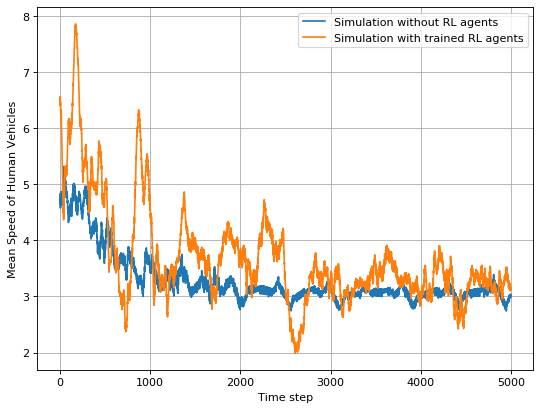

In [7]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

currentDir = '/mnt/c/users/llave/Documents/GitHub/flow_osuphysics/lucalavezzo/'
fname_sim= currentDir+'tutorial/meanSpeeds_sim.csv'
fname_trained = currentDir+'tutorial/meanSpeeds_trained.csv'

def import_data(fname):
    
    fields = []
    rows = []
    
    # reading csv file 
    with open(fname, 'r') as csvfile: 
        
        # creating a csv reader object 
        csvreader = csv.reader(csvfile) 

        # extracting field names through first row 
        fields = next(csvreader) 

        # extracting each data row one by one 
        for row in csvreader: 
            rows.append(float(row[0]))
    
    return fields, rows

sim_fields, sim_rows = import_data(fname_sim)
trained_fields, trained_rows = import_data(fname_trained)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(sim_rows,label="Simulation without RL agents")
plt.plot(trained_rows,label="Simulation with trained RL agents")
plt.ylabel("Mean Speed of Human Vehicles")
plt.xlabel("Time step")
plt.legend()
plt.grid()
plt.show()